# Get the Class names 

The [Quick Draw Dataset](https://github.com/googlecreativelab/quickdraw-dataset) is a collection of 50 million drawings across 345 categories.

In [1]:
!wget 'https://raw.githubusercontent.com/vbosstech/machine-learning-by-examples/master/Keras-TensorFlow-sketcher/quickdraw-dataset-categories.txt'

--2018-11-06 07:58:22--  https://raw.githubusercontent.com/vbosstech/machine-learning-by-examples/master/Keras-TensorFlow-sketcher/quickdraw-dataset-categories.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [text/plain]
Saving to: ‘quickdraw-dataset-categories.txt’

quickdraw-dataset-c 100%[===================>]     760  --.-KB/s    in 0s      

2018-11-06 07:58:22 (65.4 MB/s) - ‘quickdraw-dataset-categories.txt’ saved [760/760]



Read the classes names 

In [0]:
f = open("quickdraw-dataset-categories.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [0]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download the Dataset 

Loop over the classes and download the currospondent data

In [0]:
!mkdir data

In [0]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [7]:
download() 
# !ls data

airplane.npy	  circle.npy	    key.npy	      shorts.npy
alarm_clock.npy   clock.npy	    knife.npy	      shovel.npy
anvil.npy	  cloud.npy	    ladder.npy	      smiley_face.npy
apple.npy	  coffee_cup.npy    laptop.npy	      snake.npy
axe.npy		  cookie.npy	    light_bulb.npy    sock.npy
baseball_bat.npy  cup.npy	    lightning.npy     spider.npy
baseball.npy	  diving_board.npy  line.npy	      spoon.npy
basketball.npy	  donut.npy	    lollipop.npy      square.npy
beard.npy	  door.npy	    microphone.npy    star.npy
bed.npy		  drums.npy	    moon.npy	      stop_sign.npy
bench.npy	  dumbbell.npy	    mountain.npy      suitcase.npy
bicycle.npy	  envelope.npy	    moustache.npy     sun.npy
bird.npy	  eyeglasses.npy    mushroom.npy      sword.npy
book.npy	  eye.npy	    pants.npy	      syringe.npy
bread.npy	  face.npy	    paper_clip.npy    table.npy
bridge.npy	  fan.npy	    pencil.npy	      tennis_racquet.npy
broom.npy	  flower.npy	    pillow.npy	      tent.npy
butterfly.npy	  frying_pan.npy    pizza.np

# Imports 
Use **Keras** with **Tensorflow** backend

In [0]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

# Load the Data 

The data for each class is available on [Google Cloud](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap?pli=1) as numpy arrays of the shape [N,784] where N is the number of of the images for that particular class.

Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load **5000** images per class. We also reserve **20%** of the data unseen for testing.

In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 5000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [0]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [11]:
print(len(x_train))

400000


Show some random data 

sun


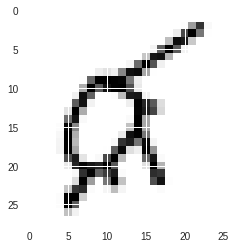

In [12]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

# Preprocess the Data 
The model will take batches of the shape [N, 28, 28, 1] and outputs probabilities of the shape [N, 100]

In [0]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model 

In [14]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(100, activation='softmax')) 
# Train model
adam = tf.train.AdamOptimizer()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
__________

# Training 

In [0]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Train on 360000 samples, validate on 40000 samples
Epoch 1/5
 - 60s - loss: 1.8285 - top_k_categorical_accuracy: 0.7980 - val_loss: 1.2932 - val_top_k_categorical_accuracy: 0.8872
Epoch 2/5
 - 52s - loss: 1.1794 - top_k_categorical_accuracy: 0.9003 - val_loss: 1.1093 - val_top_k_categorical_accuracy: 0.9075
Epoch 3/5
 - 53s - loss: 1.0303 - top_k_categorical_accuracy: 0.9162 - val_loss: 1.0268 - val_top_k_categorical_accuracy: 0.9162
Epoch 4/5


# Testing 

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

# Inference 

In [0]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

# Store the classes 

In [0]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [0]:
!pip install tensorflowjs 

# Save and Convert 

In [0]:
model.save('keras.h5')

In [0]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

# Zip and Download 

In [0]:
!cp class_names.txt model/class_names.txt

In [0]:
!zip -r model.zip model 

In [0]:
from google.colab import files
files.download('model.zip')